In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from expecto import get_spectrum  # downloads phoenix model spectra
from tqdm.auto import tqdm
from ipywidgets import interactive
from specutils import Spectrum1D

Set up the lon ($\phi$), lat ($\theta$), and orbital phase ($\xi$) grids:

In [45]:
n_obs_per_orbit = 50

n_lats = 50
n_lons = 100
phi = np.linspace(0, 2*np.pi, n_lons)

lat_frac = 0.95
theta = np.arcsin(np.linspace(-lat_frac, lat_frac, n_lats))

xi = np.linspace(-np.pi, np.pi, n_obs_per_orbit)

Rp = 1 * u.R_jup

phi2d, theta2d = np.meshgrid(
    phi, theta
)

phi3d, theta3d, xi3d = np.meshgrid(
    phi, theta, xi
)

$$ v(\phi, \theta) = \sin(\theta) $$

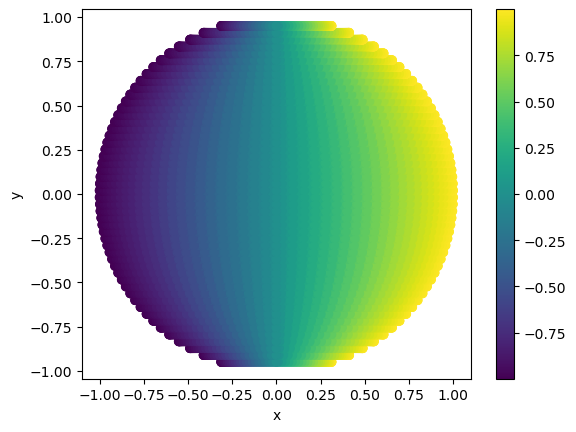

In [46]:
x = Rp * np.cos(theta3d) * np.sin(phi3d)
y = Rp * np.sin(theta3d)
z = Rp * np.sin(theta3d) * np.sin(phi3d)

dx = - np.sin(phi3d)
dy = np.cos(phi3d)
dz = np.zeros_like(phi3d)

plt.scatter(x[..., 0].value.ravel(), y[..., 0].value.ravel(), c=-dx[..., 0].ravel())
plt.colorbar()
plt.gca().set(
    xlabel='x', 
    ylabel='y'
)
plt.gca().set_aspect('equal')

In [47]:
# this visibility goes from (-1, 1)
visibility_no_clipping = np.cos(phi3d - np.pi - xi) * np.sin(theta3d + np.pi/2)**2

# this visibility has minimum = 0
visibility = np.cos(phi3d - np.pi - xi) * np.sin(theta3d + np.pi/2)**2
visibility[visibility < 0] = 0

Silly idea: in the (top-most) upper atmosphere, the angle of incident instellation probably correlates with temperature:
$${\rm visibility} \propto T$$

And maybe we can use GCMs to figure out if this proportionality is roughly true:
$${\rm wind~velocity} \propto - \frac{dT}{d\phi}$$

So maybe we can parameterize the terminator line-of-sight velocities from the temperature gradient like:
$$ v_\phi \approx - c\frac{dT}{d\phi}$$

How bad is this assumption high in the atmosphere (_at the top_)?

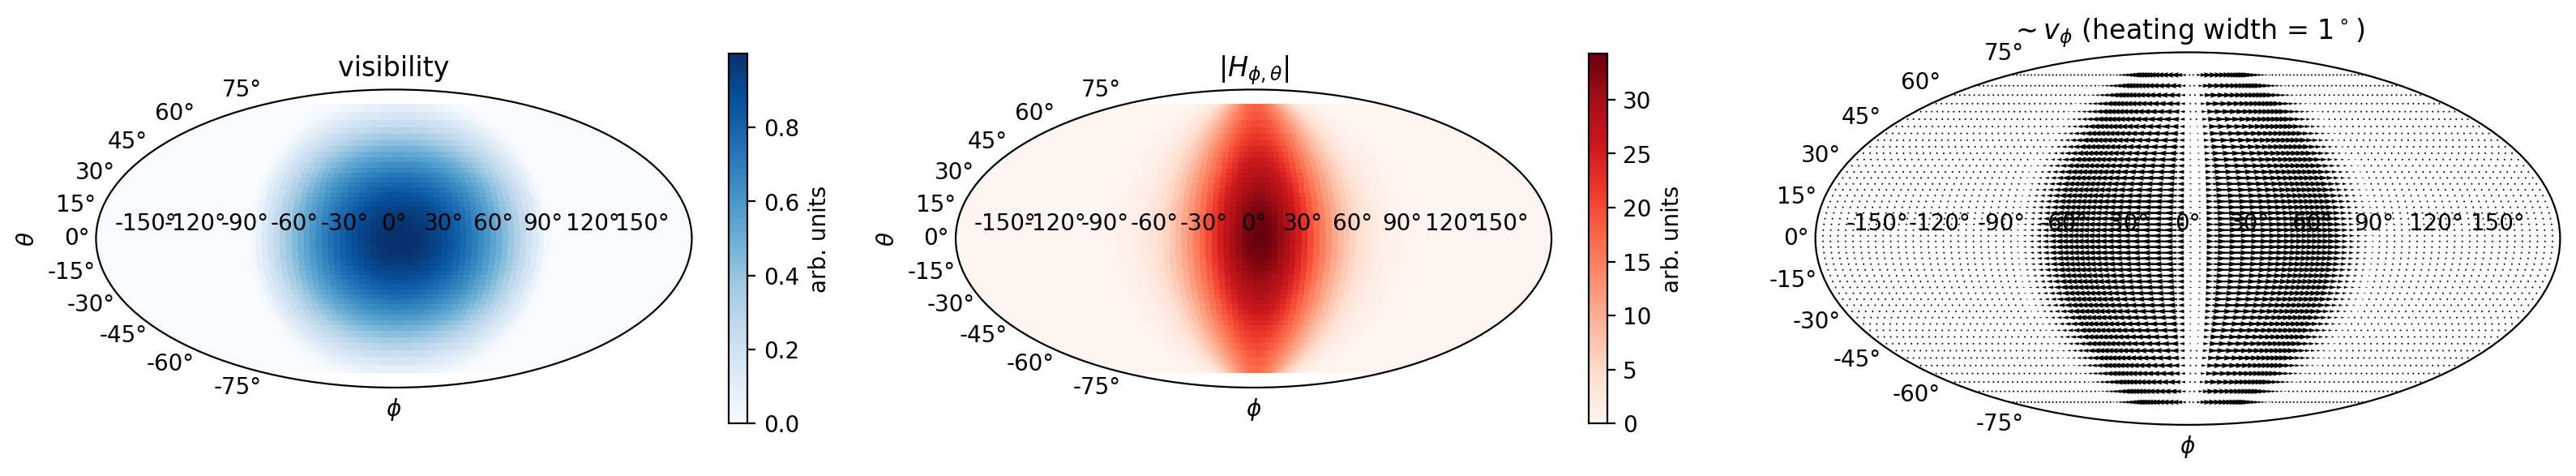

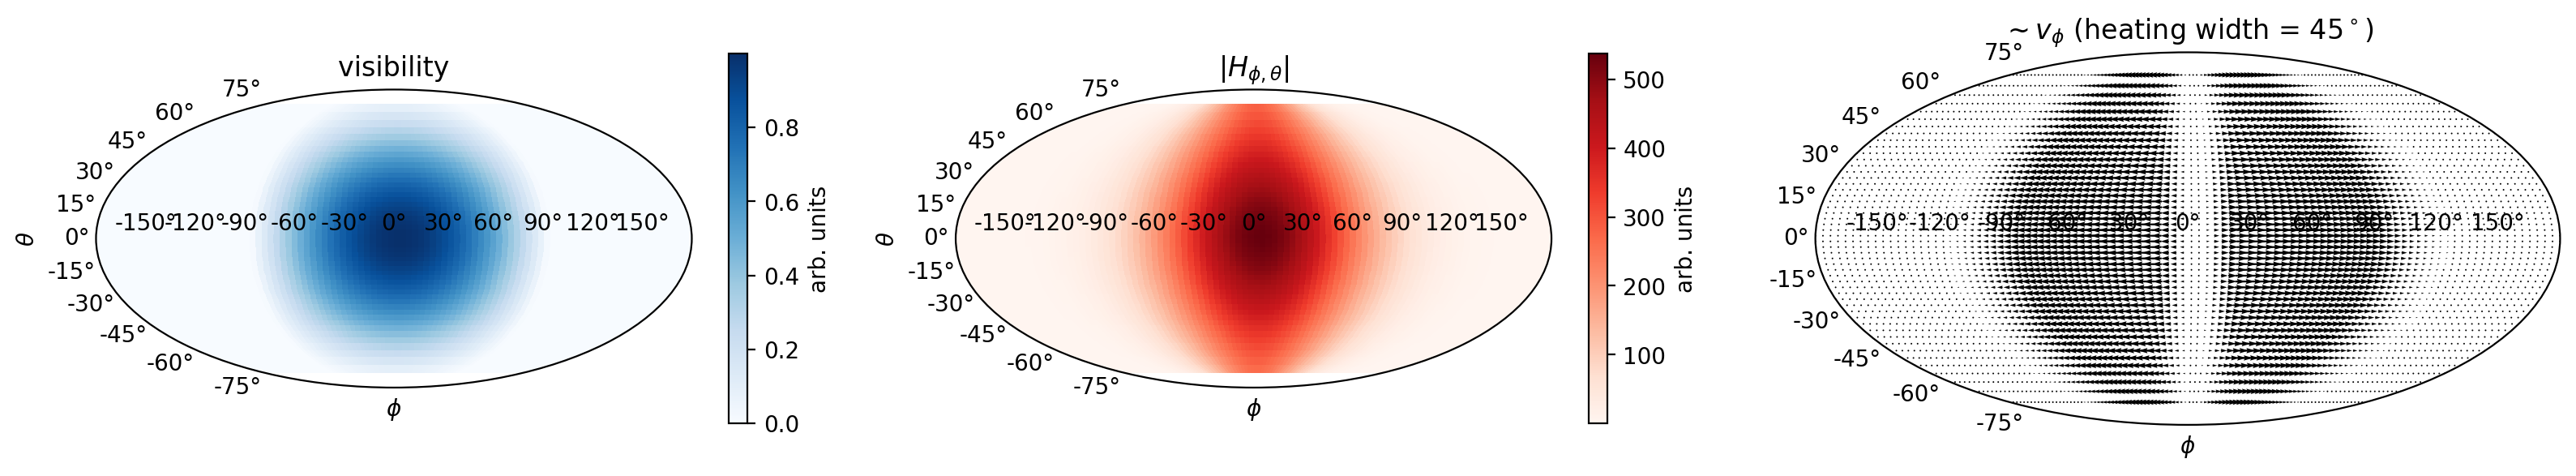

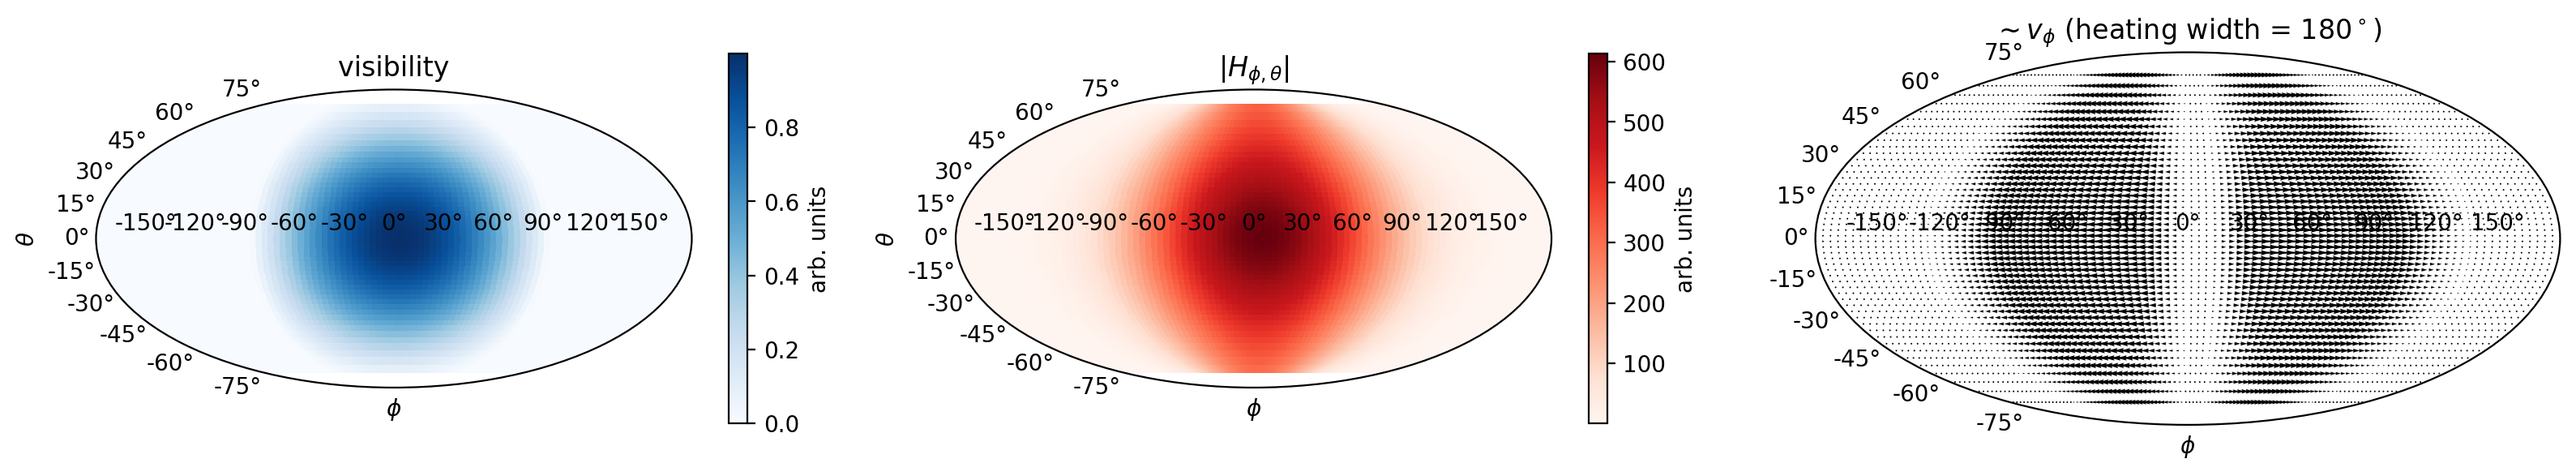

In [195]:
from scipy.signal import convolve2d

for heating_width in [0.01, np.pi/4, np.pi]: # radians
    # fig, ax = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True, dpi=200)
    fig = plt.figure(figsize=(16, 6), dpi=200)
    
    ax = [
        fig.add_subplot(130 + i, projection='mollweide')
        for i in range(1, 4)
    ]


    time_step = visibility.shape[-1] // 2
    hotspot_lon = phi[len(phi)//2]
    
    visibility_at_eclipse = visibility[..., time_step]
    visibility_and_heating = (
        # visibility term that goes as cos(incident flux angle):
        visibility_at_eclipse * 
        # heating term that concentrates heat near subsolar point:
        np.exp(-0.5 * (phi - hotspot_lon)**2 / heating_width ** 2)
    )
    
    
    phi_smooth = np.radians(30)  # smooth stddev

    # smooth in phi, not in theta:
    kernel = np.exp(-0.5 * (phi2d - np.pi)**2 / phi_smooth**2)
    pseudo_heating =  convolve2d(visibility_and_heating, kernel, mode='same')

    dv_dphi = - np.gradient(visibility_and_heating, phi - hotspot_lon, axis=1)
    dv_dtheta = - np.gradient(visibility_and_heating, theta, axis=0)
    
    dh_dphi = - np.gradient(pseudo_heating, phi - hotspot_lon, axis=1)
    dh_dtheta = - np.gradient(pseudo_heating, theta, axis=0)

    c = ax[0].pcolormesh(phi2d - np.pi, theta2d, visibility_at_eclipse, cmap='Blues')
    ax[0].set(
        xlabel='$\phi$',
        ylabel='$\\theta$',
        title='visibility'
    )
    plt.colorbar(c, ax=ax[0], label='arb. units', shrink=0.4)
    c = ax[1].pcolormesh(phi2d - np.pi, theta2d, pseudo_heating, cmap='Reds')
    ax[1].set(
        xlabel='$\phi$',
        ylabel='$\\theta$',
        title='|$H_{\phi, \\theta}}$|'
    )
    plt.colorbar(c, ax=ax[1], label='arb. units', shrink=0.4)
    c = ax[2].quiver(phi - np.pi, theta, dh_dphi, np.zeros_like(dh_dphi), angles='xy')
    ax[2].set(
        xlabel='$\phi$',
        title=f'$\sim v_\phi$ (heating width = {np.degrees(heating_width):.0f}$^\circ$)'
    )
    
    # for axis in ax:
    #     axis.set_aspect(0.8)
    fig.tight_layout()
    plt.show()

* "visibility" is proportional to the angle between the surface normal and the incident instellation
* $|H_{\phi, \theta}|$ is an attempt to parameterize the atmospheric heating on the dayside – this starts with the "visibility" map on the left, and it's multiplied by a Gaussian heating function in longitude. There's a "heating width" parameter that concentrates flux beneath the substellar point.
* $\sim v_\phi$ may be proportional to the wind velocity along lines of latitude, and it's computed from $v \sim -\frac{dH}{d\phi}$ 